In [1]:
import numpy as np
import scipy.integrate as integrate

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
%config InlineBackend.figure_format='retina'

In [2]:
"""Cartesian velocity to Spherical velocity."""
def c_to_s_vel(pos,vel): # both in cartesian!
    s_vel = []
    for i, c_vel in enumerate(vel):
        xd,yd,zd = c_vel[0],c_vel[1],c_vel[2]
        x,y,z = pos[i][0],pos[i][1],pos[i][2]
        rd = (x*xd+y*yd+z*zd)/np.sqrt(pow(x,2)+pow(y,2)+pow(z,2))
        td = (xd*y-x*yd)/(pow(x,2)+pow(y,2))
        pd = (z*(x*xd+y*yd)-(pow(x,2)+pow(y,2))*zd)/((pow(x,2)+pow(y,2)+pow(z,2))*np.sqrt(pow(x,2)+pow(y,2)))
        s_vel.append([rd,td,pd])
    return s_vel

In [3]:
"""Spherical velocity to Cartesian velocity."""
def s_to_c_vel(pos,vel): # position in cartesian, velocity in spherical!
    c_vel = []
    for i, s_vel in enumerate(vel):
        rd,td,pd = s_vel[0],s_vel[1],s_vel[2]
        x,y,z = pos[i][0],pos[i][1],pos[i][2]
        xd = (x/np.sqrt(pow(x,2)+pow(y,2)+pow(z,2)))*rd+y*td+((z*x)/np.sqrt(pow(x,2)+pow(y,2)))*pd
        yd = (y/np.sqrt(pow(x,2)+pow(y,2)+pow(z,2)))*rd-x*td+((z*y)/np.sqrt(pow(x,2)+pow(y,2)))*pd
        zd = (z/np.sqrt(pow(x,2)+pow(y,2)+pow(z,2)))*rd-(np.sqrt(pow(x,2)+pow(y,2))*pd)
        c_vel.append([xd,yd,zd])
    return c_vel

In [4]:
"""Cartesian position to spherical position."""
def cart_to_sph(arr):
    sph_list = []
    for coord in arr:
        x,y,z = coord[0],coord[1],coord[2]
        r  = np.sqrt(pow(x,2)+pow(y,2)+pow(z,2))
        th = np.arccos(z/r)
        ph = np.arctan2(y,x)
        sph_list.append([r,th,ph])
    return sph_list

In [5]:
"""Spherical position to cartesian position."""
def sph_to_cart(arr):
    cart_list = []
    for coord in arr:
        r,t,p = coord[0],coord[1],coord[2]
        x = r*np.sin(t)*np.cos(p)
        y = r*np.sin(t)*np.sin(p)
        z = r*np.cos(t)
        cart_list.append([x,y,z])
    return cart_list

From electrodynamics, we know that the motion (Lorentz force) experienced by a particle goes as:
$$
\begin{align}
 \frac{\vec{F}}{m} & = \vec{a} = \frac{d\vec{v}}{dt},\\
 \frac{d\vec{v}}{dt} & = \frac{q}{m}(\vec{v}\times\vec{B}),\\
 \frac{d\vec{v}}{dt} & = \gamma_{e}(\vec{v}\times\vec{B})
   \end{align} $$

In [6]:
def lorentz(t,R):
    r, theta, phi    = R[0], R[1], R[2] # retrieve spherical positions,
    vr, vtheta, vphi = R[3], R[4], R[5] # spherical velocities.

    bt  = (-B0*(RE/r)**3)*np.sin(theta+alpha)
    br = (-2*(B0*(RE/r)**3)*np.cos(theta+alpha))
    if r==0:
        r = 1
    return np.array([vr,vtheta,vphi, 
                    -vphi*(gyr)*(bt), 
                     vphi*(gyr)*(br), 
                     (gyr)*(bt)*vr-vtheta*(gyr)*(br)])

In [7]:
dt = 0.1
t  = np.arange(0.0, 500, dt)

# gyroscopic ratio is set for electron. Magnetic field of Earth [Telsa]. Radius of the Earth is scaled to 1.
gyr = 1.76e11; B0 = 3.12e-5; RE = 1; alpha = np.radians(0);

In [8]:
gyr = 1; B0 = 1; RE = 1;

In [40]:
N = 1

In [41]:
randy = (np.random.random(N)*6)-3
randz = (np.random.random(N)*6)-3

In [42]:
randvx = np.random.normal(loc=-0.078480615288,scale=0.039240307644/2,size=N)
randvy = np.random.normal(loc=0,scale=0.078/10,size=N)
randvz = np.random.normal(loc=0,scale=0.078/10,size=N)

In [43]:
x0 = []
for i,item in enumerate(randy):
    x0.append([2, randy[i], randz[i]])
#     x0.append([2,1,1])

v0 = []
for i,item in enumerate(randvx):
    v0.append([randvx[i], randvy[i], randvz[i]])
#     v0.append([1,1,1])
    
v0 = c_to_s_vel(x0,v0) # both inputs need to be cartesian!
x0 = cart_to_sph(x0)   # now we can convert positions to spherical.
# print(v0)

<IPython.core.display.Javascript object>


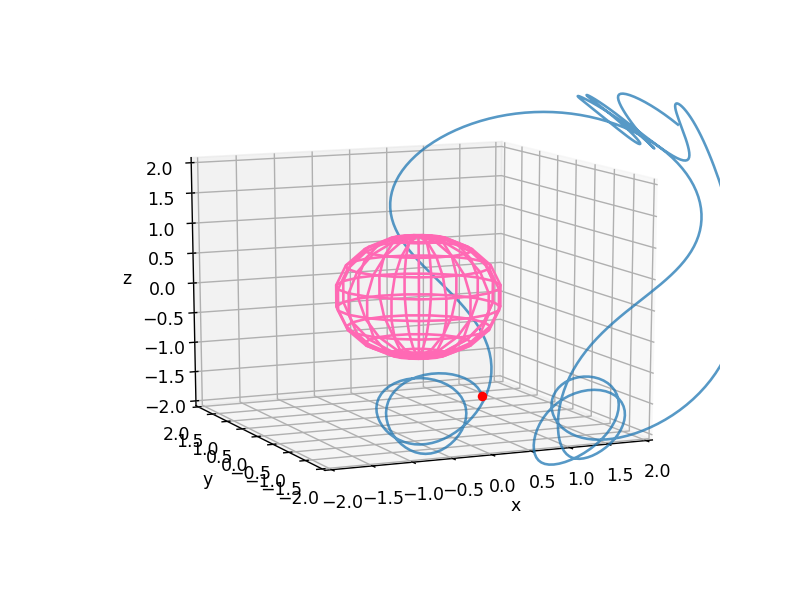

In [44]:
posList = []
for index, particle in enumerate(x0):
    initial_conditions = np.concatenate((x0[index], v0[index]))
    positions = integrate.odeint(func=lorentz,y0=initial_conditions,t=t,tfirst=True)
    posList.append(positions)
#     print(np.shape(positions[:,0]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # initialize a 3-D plot.

for positions in posList:
    cart = np.array(sph_to_cart(positions[:,:3]))
    cartvel = np.array(s_to_c_vel(cart, positions[:,3:6]))

    ax.plot3D(cart.T[0], cart.T[1], cart.T[2],alpha=0.75) # solution x, y, z
    ax.scatter3D(cart.T[0][0],cart.T[1][0],cart.T[2][0],color='red')

plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')

c = 2;
plt.xlim(-c,c)
plt.ylim(-c,c)
ax.set_zlim(-c,c)

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="hotpink")

# This frustratingly makes little sense. Let's try implementing everything in cartesian:

### Seems like this is more straightforward, but it's still not working. I suspect that I misunderstand the return values for my lorentz function

$$ B_x = 3M\frac{xz}{r^5} $$\
$$ B_y = 3M\frac{yz}{r^5} $$\
$$ B_z = M\frac{(3z^2-r^2)}{r^5} $$

In [45]:
def lorentzC(t,R):
    x, y, z    = R[0], R[1], R[2] # retrieve cartesian positions,
    vx, vy, vz = R[3], R[4], R[5] # velocities.
    
    r  = np.sqrt(x**2+y**2+z**2)
    bx = 3*M*((x*z)/r**5)         # cartesian dipole components.
    by = 3*M*((y*z)/r**5)
    bz = M*((3*z**2-r**2)/r**5)

    return np.array([vx,vy,vz,
                     gyr*(vy*bz-vz*by),       # (v x B)xhat
                     gyr*(vz*bx-vx*bz),       # (v x B)yhat
                     gyr*(vx*by-vy*bx)])      # (v x B)zhat

In [46]:
# dt = 0.0001
# t  = np.arange(0.0, 0.02, dt)
dt = 1
t  = np.arange(0.0, 500, dt)

# gyroscopic ratio is set for electron. Magnetic field of Earth [Telsa]. Radius of the Earth is scaled to 1.
gyr = 1.76e11; B0 = 3.12e-5; RE = 1; alpha = np.radians(0); M = -1.2557*10**9;

In [54]:
M = (-1/32325); gyr = 1760000
# M = (-1/32325); gyr = 176000*1e6

#### These values are mysterious. M is set by T*m^3 scaled to earth radii. gyr is a constant for electrons. When we change gyr to be quite large (the value it should be), things break.

In [55]:
x0 = []
for i,item in enumerate(randy):
    x0.append([2, randy[i], randz[i]])
#     x0.append([1.5, 0.0, 0.5])

v0 = []
for i,item in enumerate(randvx):
    v0.append([randvx[i], randvy[i], randvz[i]])
#     v0.append([-0.1, 0.01, 0.01])

<IPython.core.display.Javascript object>


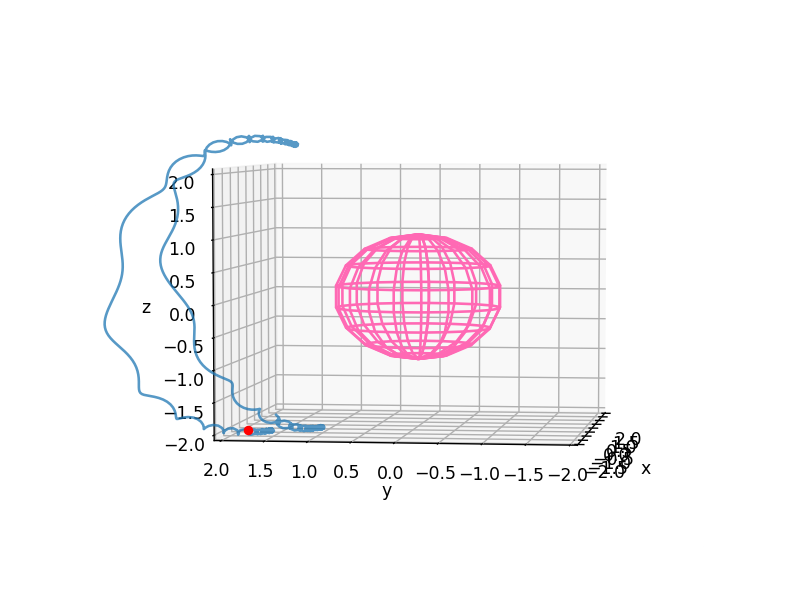

In [56]:
posList = []
for index, particle in enumerate(x0):
    initial_conditions = np.concatenate((x0[index], v0[index]))
    positions = integrate.odeint(func=lorentzC,y0=initial_conditions,t=t,tfirst=True)
    posList.append(positions)
#     print(np.shape(positions[:,0]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # initialize a 3-D plot.

for positions in posList:
    cart = np.array(positions[:,:3])
    cartvel = np.array(positions[:,3:6])

    ax.plot(cart.T[0], cart.T[1], cart.T[2],alpha=0.75) # solution x, y, z
    ax.scatter3D(cart.T[0][0],cart.T[1][0],cart.T[2][0],color='red')

plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')

c = 2;
plt.xlim(-c,c)
plt.ylim(-c,c)
ax.set_zlim(-c,c)

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="hotpink")

In [57]:
from tempfile import NamedTemporaryFile
import base64 
from matplotlib import animation
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        f = NamedTemporaryFile(suffix='.mp4', delete=False)
        anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
        f.flush()
        video = open(f.name, "rb").read()
        f.close()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    
    return VIDEO_TAG.format(anim._encoded_video)

In [58]:
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

<IPython.core.display.Javascript object>


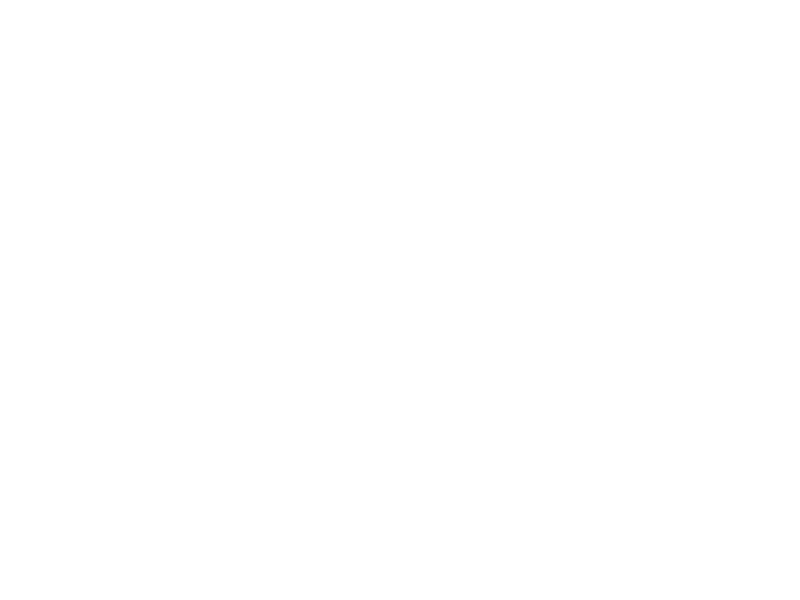

In [59]:
FRAMES = 500
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def init():
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
# animation function.  This is called sequentially
def animate(i):
    current_index = int(positions.shape[0] / FRAMES * i)
    ax.cla()
    ax.plot3D(cart.T[0][:current_index], 
              cart.T[1][:current_index], 
              cart.T[2][:current_index])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
# call the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=FRAMES, interval=500)

# call our new function to display the animation
display_animation(anim)

Interesting! This is reminiscent of a magnetic mirroring phenomena! Although, things aren't working the way they really should be. We need to re-examine how we define and utilize our units and subsequent parameters.

# ERROR: Examine the cross product return values. They should be xhat, yhat, zhat components rather than (vx x B), (vy x B), (vz x B)

### Upon fixing this, we finally see the particles shift towards the poles!